## 타이타닉  생존자 예측 ML 구현
 * DecisionTree, RandomForest, LogisticRegression
 * KFold
 * cross_val_score(), GridSearchCV()

### 코드 출처 : https://github.com/chulminkw/PerfectGuide

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

titanic_df = pd.read_csv('./train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


* Passengerid: 탑승자 데이터 일련번호
* survived: 생존 여부, 0 = 사망, 1 = 생존
* Pclass: 티켓의 선실 등급, 1 = 일등석, 2 = 이등석, 3 = 삼등석
* sex: 탑승자 성별
* name: 탑승자 이름
* Age: 탑승자 나이
* sibsp: 같이 탑승한 형제자매 또는 배우자 인원수
* parch: 같이 탑승한 부모님 또는 어린이 인원수
* ticket: 티켓 번호
* fare: 요금
* cabin: 선실 번호
* embarked: 중간 정착 항구 C = Cherbourg, Q = Queenstown, S = Southampton

In [3]:
print('\n ### train 데이터 정보 ### \n')
print(titanic_df.info())


 ### train 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [4]:
titanic_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


**NULL 값 처리**

* 결손치가 발생한 Columns : Age, Cabin, Embarked

In [5]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace = True)
titanic_df['Embarked'].fillna('N', inplace=True)

In [7]:
print('Null 확인 : ', titanic_df.isnull().sum())
#print(titanic_df.isnull().sum().sum()) 전체 null 값을 볼 수 있음

Null 확인 :  PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


**주요 컬럼 EDA**
* Name, Sex, Ticket, Cabin, Embarked

In [15]:
display('Sex 값 분포', titanic_df['Sex'].value_counts().to_frame())
display('Cabin 값 분포', titanic_df['Cabin'].value_counts().to_frame())
display('Embarked 값 분포', titanic_df['Embarked'].value_counts().to_frame())

'Sex 값 분포'

,Sex
male,577
female,314


'Cabin 값 분포'

,Cabin
N,687
C23 C25 C27,4
G6,4
B96 B98,4
C22 C26,3
...,...
E34,1
C7,1
C54,1
E36,1


'Embarked 값 분포'

,Embarked
S,644
C,168
Q,77
N,2


* Cabin의 값이 다양하기 때문에 앞의 문자만 추출하여 값을 단순화한다

In [18]:
titanic_df['Cabin'].str[:1]

0      N
1      C
2      N
3      C
4      N
      ..
886    N
887    B
888    N
889    C
890    N
Name: Cabin, Length: 891, dtype: object

In [19]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
titanic_df['Cabin'].head(3)

0    N
1    C
2    N
Name: Cabin, dtype: object

### Survived

In [21]:
titanic_df.Survived.value_counts().to_frame()

,Survived
0,549
1,342


### Survived vs Sex

In [20]:
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count().to_frame()

Survived
Sex    Survived          
female 0               81
       1              233
male   0              468
       1              109

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

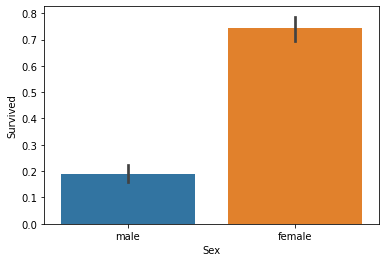

In [22]:
sns.barplot(x = 'Sex', y = 'Survived', data = titanic_df)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

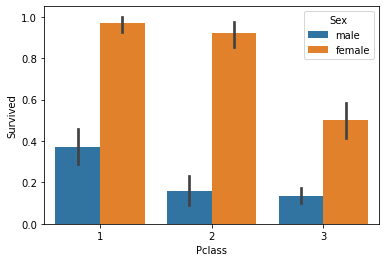

In [23]:
sns.barplot(x = 'Pclass', y = 'Survived', hue='Sex', data = titanic_df)

### Survived vs Age

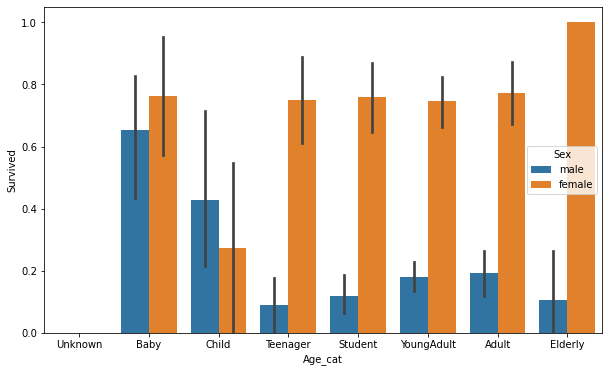

In [24]:
def get_category(age):
    cat = ''
    if age <= -1 : cat = 'Unknown'
    elif age <= 5 : cat = 'Baby'
    elif age <= 12 : cat = 'Child'
    elif age <= 18 : cat = 'Teenager'
    elif age <= 25 : cat = 'Student'
    elif age <= 35 : cat = 'YoungAdult'
    elif age <= 60 : cat = 'Adult'
    else : cat = 'Elderly'
        
    return cat

#barplot size up
plt.figure(figsize = (10, 6))

#x축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'YoungAdult', 'Adult', 'Elderly']

titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))

sns.barplot(x = 'Age_cat', y = 'Survived', hue = 'Sex', data = titanic_df, order = group_names)
titanic_df.drop('Age_cat', axis = 1, inplace = True)

### Encoding

In [26]:
from sklearn.preprocessing import LabelEncoder

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    le = LabelEncoder()
    for feature in features : 
        dataDF[feature] = le.fit_transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


* 앞선 과정들을 한번에 처리할 수 있도록 함수로 정리

In [27]:
# Null 처리
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    return df

# 불필요한 columns drop
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
    return df

# Label Encoding
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
    return df

# 앞선 Preprocessing function 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [29]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


**Model Training**

In [31]:
# 원본 데이터를 재로딩 하고, feature 데이터 셋과 label 데이터 셋 추출.
titanic_df = pd.read_csv('./train.csv')
y_df = titanic_df['Survived']
x_df = titanic_df.drop('Survived', axis = 1, inplace = False)

x_df = transform_features(x_df)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df,
                                                    test_size = 0.2, random_state=11)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(712, 8) (179, 8) (712,) (179,)


In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create DecisionTree, RandomForest, LogisticRefreesion Estimator 
# 기존 LogisticRegression의 solver default는 liblinear였으나 현재는 lbfgs로 변함
dt_clf = DecisionTreeClassifier(random_state = 11)
rf_clf = RandomForestClassifier(random_state = 11)
lib_clf = LogisticRegression(solver = 'liblinear')
lr_clf = LogisticRegression()

# DecisionTreeClassifier train/predict/evaluation
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier accuracy : {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier train/predict/evaluation
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier accuracy : {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression(solver = 'liblinear') train/predict/evaluation
lib_clf.fit(X_train, y_train)
lib_pred = lib_clf.predict(X_test)
print('LogisticRegression(solver=liblinear) accuracy : {0:.4f}'.
     format(accuracy_score(y_test, lib_pred)))

# LogisitcRegression train/predict/evaluation
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression accuracy : {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier accuracy : 0.7877
RandomForestClassifier accuracy : 0.8547
LogisticRegression(solver=liblinear) accuracy : 0.8659
LogisticRegression accuracy : 0.8492


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
x_df.values[[0, 1, 2, 3, 4, 5]]

array([[ 3.        ,  1.        , 22.        ,  1.        ,  0.        ,
         7.25      ,  7.        ,  3.        ],
       [ 1.        ,  0.        , 38.        ,  1.        ,  0.        ,
        71.2833    ,  2.        ,  0.        ],
       [ 3.        ,  0.        , 26.        ,  0.        ,  0.        ,
         7.925     ,  7.        ,  3.        ],
       [ 1.        ,  0.        , 35.        ,  1.        ,  0.        ,
        53.1       ,  2.        ,  3.        ],
       [ 3.        ,  1.        , 35.        ,  0.        ,  0.        ,
         8.05      ,  7.        ,  3.        ],
       [ 3.        ,  1.        , 29.69911765,  0.        ,  0.        ,
         8.4583    ,  7.        ,  2.        ]])

**교차검증**

In [41]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds = 5):
    kfold = KFold(n_splits = folds)
    scores = []
    
    # KFold 교차 검증 수행
    for iter_count, (train_index, test_index) in enumerate(kfold.split(x_df)):
        # x_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = x_df.values[train_index], x_df.values[test_index]
        y_train, y_test = y_df.values[train_index], y_df.values[test_index]
        
        # Classifier train, predict, evaluation
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도 : {1:.4f}".format(iter_count, accuracy))
        
    # 5개 fold에서 평균 정확도 계산
    mean_score = np.mean(scores)
    print('평균 정확도 : {0:.4f}'.format(mean_score))
    
# exec_kfold 호출
exec_kfold(dt_clf, folds = 5)

교차 검증 0 정확도 : 0.7542
교차 검증 1 정확도 : 0.7809
교차 검증 2 정확도 : 0.7865
교차 검증 3 정확도 : 0.7697
교차 검증 4 정확도 : 0.8202
평균 정확도 : 0.7823


In [46]:
print('DecisionTree 교차 검증')
exec_kfold(dt_clf, folds = 5)

print('\n RandomForest 교차 검증')
exec_kfold(rf_clf, folds = 5)

print('\n LogisticRegression solver=liblinear 교차 검증')
exec_kfold(lib_clf, folds = 5)

print('\n LogisticRegression solver=default 교차 검증')
exec_kfold(lr_clf, folds = 5)

DecisionTree 교차 검증
교차 검증 0 정확도 : 0.7542
교차 검증 1 정확도 : 0.7809
교차 검증 2 정확도 : 0.7865
교차 검증 3 정확도 : 0.7697
교차 검증 4 정확도 : 0.8202
평균 정확도 : 0.7823

 RandomForest 교차 검증
교차 검증 0 정확도 : 0.7933
교차 검증 1 정확도 : 0.8090
교차 검증 2 정확도 : 0.8371
교차 검증 3 정확도 : 0.7753
교차 검증 4 정확도 : 0.8596
평균 정확도 : 0.8148

 LogisticRegression solver=liblinear 교차 검증
교차 검증 0 정확도 : 0.7933
교차 검증 1 정확도 : 0.7921
교차 검증 2 정확도 : 0.7753
교차 검증 3 정확도 : 0.7472
교차 검증 4 정확도 : 0.8427
평균 정확도 : 0.7901

 LogisticRegression solver=default 교차 검증
교차 검증 0 정확도 : 0.8045
교차 검증 1 정확도 : 0.7809
교차 검증 2 정확도 : 0.7753
교차 검증 3 정확도 : 0.7584
교차 검증 4 정확도 : 0.8258
평균 정확도 : 0.7890


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

**cross_val_score**

In [47]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, x_df, y_df, cv = 5)
for iter_count, accuracy in enumerate(scores):
    print('교차 검증 {0} 정확도 : {1:.4f}'.format(iter_count, accuracy))
    
print('평균 정확도 : {0:.4f}'.format(np.mean(scores)))

교차 검증 0 정확도 : 0.7430
교차 검증 1 정확도 : 0.7753
교차 검증 2 정확도 : 0.7921
교차 검증 3 정확도 : 0.7865
교차 검증 4 정확도 : 0.8427
평균 정확도 : 0.7879


**GridSearchCV**

In [54]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth' : [2, 3, 5, 10],
             'min_samples_split' : [2, 3, 5],
             'min_samples_leaf' : [1, 5, 8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring ='accuracy', cv = 5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도 : {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

#GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도 : 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715
